In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

Attempting to load image from path: c:/Users/jayvo/Desktop/Project/Image_Recognition-Project/Objects2/O10.jpeg


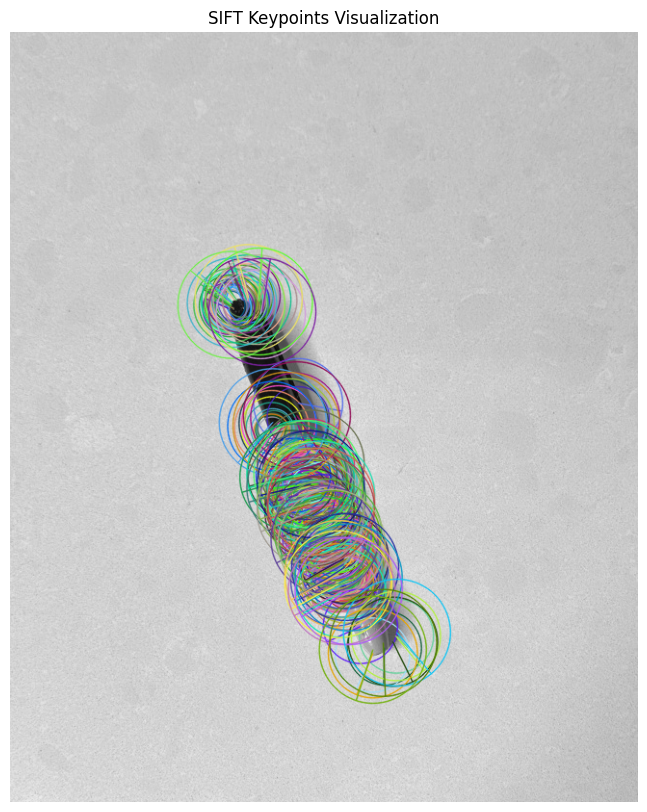

Number of keypoints detected: 498


In [4]:
def visualize_keypoints(image_path, orb):
    """
    Detect and visualize keypoints in a single image.
    """
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return

    # Detect keypoints and compute descriptors
    keypoints, descriptors = orb.detectAndCompute(img, None)

    # Draw the keypoints on the image
    img_with_keypoints = cv2.drawKeypoints(
        img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    # Convert image to RGB for matplotlib visualization
    img_with_keypoints = cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB)

    # Display the image with keypoints
    plt.figure(figsize=(10, 10))
    plt.title('SIFT Keypoints Visualization')
    plt.imshow(img_with_keypoints)
    plt.axis('off')
    plt.show()

    print(f"Number of keypoints detected: {len(keypoints)}")

# Initialize SIFT detector
orb = cv2.ORB_create()

# Path to your image (update with your actual path)
image_path = "c:/Users/jayvo/Desktop/Project/Image_Recognition-Project/Objects2/O10.jpeg"  # Replace with the actual image path
print(f"Attempting to load image from path: {image_path}")
# Visualize keypoints in the image
visualize_keypoints(image_path, orb)

In [25]:
def image_detect_and_compute(detector, img_name, apply_clahe=True, apply_blur=True, blur_type="gaussian", kernel_size=5):
    """
    Detect and compute interest points and their descriptors with optional CLAHE and blurring.
    
    Args:
        detector: Feature detector (e.g., SIFT) object.
        img_name: Name of the image file.
        apply_clahe: Apply CLAHE to enhance contrast. Default is True.
        apply_blur: Apply blurring (Gaussian or Median) to reduce noise. Default is True.
        blur_type: Type of blur to apply ('gaussian' or 'median'). Default is 'gaussian'.
        kernel_size: Kernel size for the blur. Must be an odd number for median blur. Default is 5.
    
    Returns:
        img: Preprocessed grayscale image.
        kp: Keypoints detected in the image.
        des: Descriptors corresponding to the keypoints.
    """
    # Load image and convert to grayscale
    img = cv2.imread(os.path.join(image_path, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE
    if apply_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img = clahe.apply(img)

    # Apply blurring
    if apply_blur:
        if blur_type == "gaussian":
            img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
        elif blur_type == "median":
            img = cv2.medianBlur(img, kernel_size)

    # Detect keypoints and compute descriptors
    kp, des = detector.detectAndCompute(img, None)

    return img, kp, des

def match_and_verify(detector, obj_img_name, scene_img_name):
    """Detect and verify spatially consistent keypoints."""
    # Detect and compute keypoints and descriptors
    obj_img, obj_kp, obj_des = image_detect_and_compute(detector, obj_img_name, apply_clahe=True, apply_blur=True, blur_type="median", kernel_size=5)
    scene_img, scene_kp, scene_des = image_detect_and_compute(detector, scene_img_name, apply_clahe=True, apply_blur=True, blur_type="median", kernel_size=5)

    # Match descriptors using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(obj_des, scene_des)
    matches = sorted(matches, key=lambda x: x.distance)  # Sort by distance

    # Extract coordinates of matched keypoints
    obj_pts = np.float32([obj_kp[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    scene_pts = np.float32([scene_kp[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Compute homography using RANSAC
    H, mask = cv2.findHomography(obj_pts, scene_pts, cv2.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()  # Inlier/outlier mask

    # Validate matches using bounding box
    h, w = obj_img.shape
    obj_corners = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
    scene_corners = cv2.perspectiveTransform(obj_corners, H)

    # Draw bounding box on the scene
    scene_img_box = cv2.polylines(
        scene_img.copy(), [np.int32(scene_corners)], isClosed=True, color=255, thickness=3
    )

    # Visualize matches
    draw_params = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=matches_mask, flags=2)
    match_img = cv2.drawMatches(obj_img, obj_kp, scene_img_box, scene_kp, matches, None, **draw_params)

    plt.figure(figsize=(12, 6))
    plt.imshow(match_img, cmap="gray")
    plt.title("Spatially Consistent Matches")
    plt.axis("off")
    plt.show()

    return H, matches_mask


def draw_image_matches(detector, img1_name, img2_name, nmatches=10):
    """Draw ORB feature matches of the given two images."""
    img1, kp1, des1 = image_detect_and_compute(detector, img1_name, apply_clahe=True, apply_blur=True, blur_type="median", kernel_size=5)
    img2, kp2, des2 = image_detect_and_compute(detector, img2_name, apply_clahe=True, apply_blur=True, blur_type="median", kernel_size=5)   
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x: x.distance) # Sort matches by distance.  Best come first.
    
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:nmatches], img2, flags=2) # Show top 10 matches
    plt.figure(figsize=(16, 16))
    plt.title(type(detector))
    plt.imshow(img_matches); plt.show()

Visualizing keypoints for the object image...


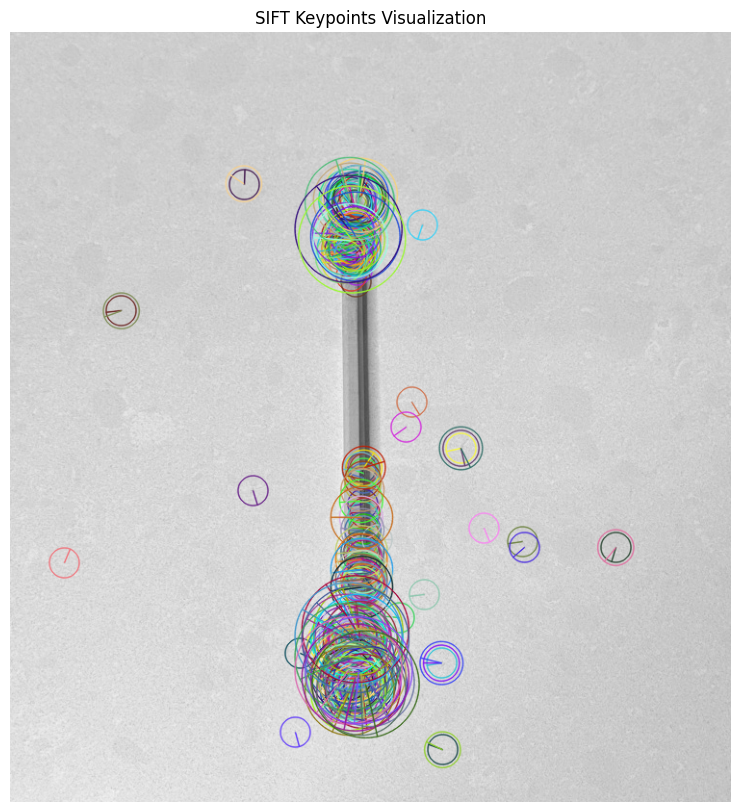

Number of keypoints detected: 319
Visualizing keypoints for the scene image...


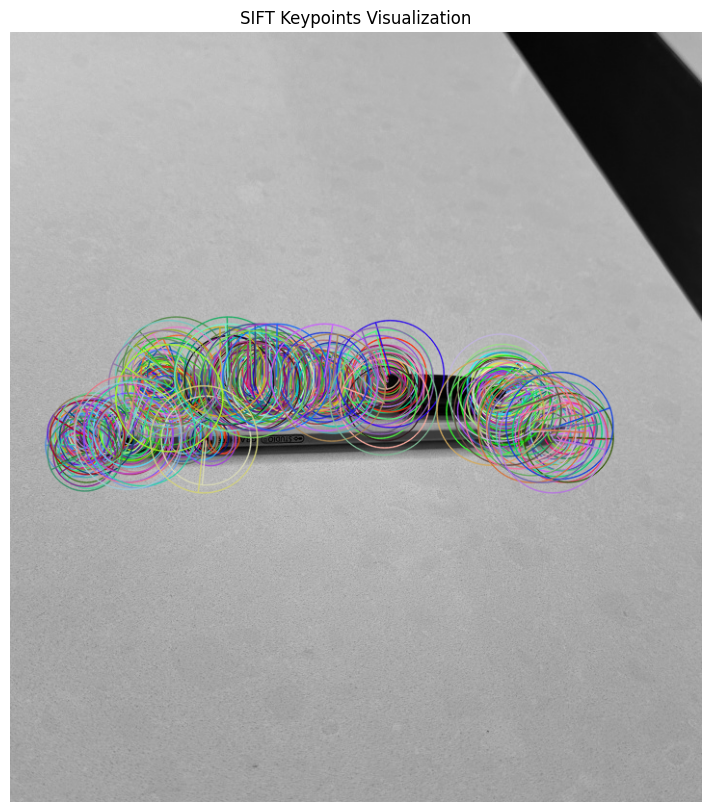

Number of keypoints detected: 498
Matching object to scene...


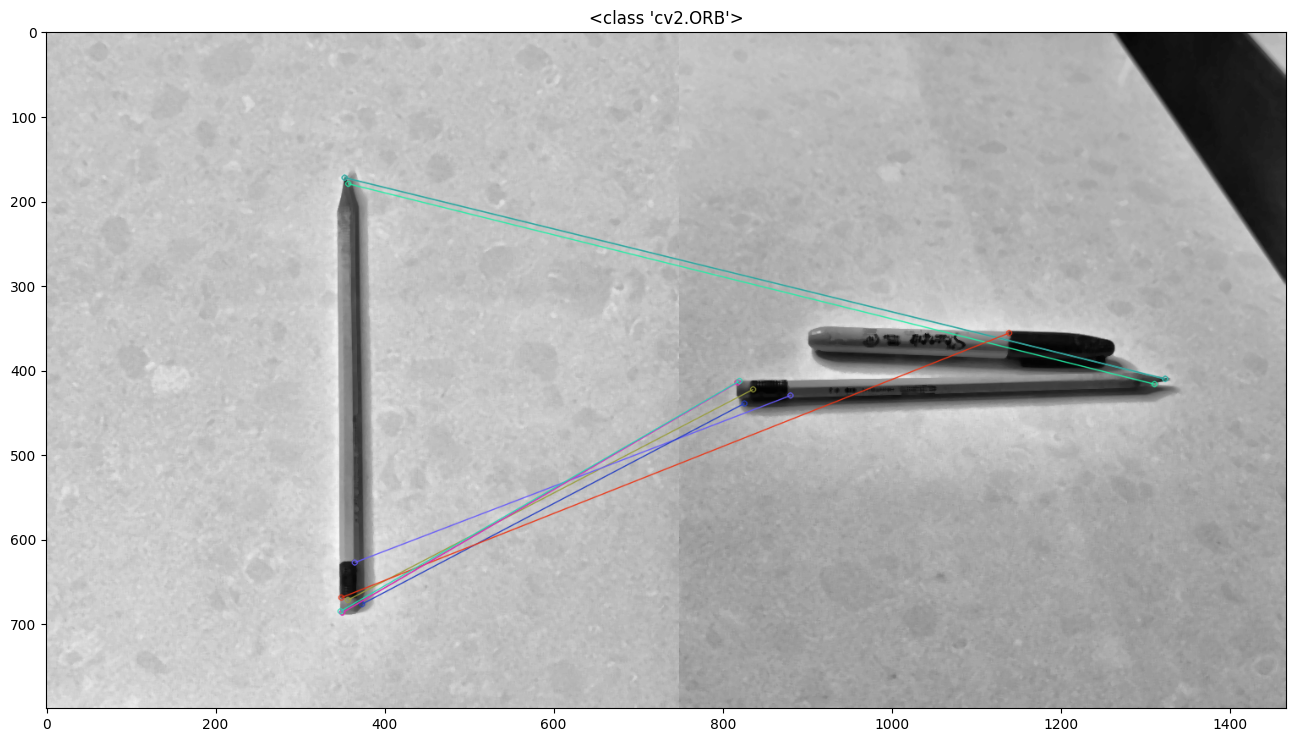

In [33]:
scene_image_path = "c:/Users/jayvo/Desktop/Project/Image_Recognition-Project/Scenes2/S2_right.jpeg"  # Replace with your scene image path
object_image_path = "c:/Users/jayvo/Desktop/Project/Image_Recognition-Project/Objects2/O3.jpeg"  # Replace with your object image path

orb = cv2.ORB_create()

# Visualize keypoints for the object and the scene
print("Visualizing keypoints for the object image...")
visualize_keypoints(object_image_path, orb)

print("Visualizing keypoints for the scene image...")
visualize_keypoints(scene_image_path, orb)

# Draw and display matches
print("Matching object to scene...")
draw_image_matches(orb, object_image_path, scene_image_path, nmatches=10)


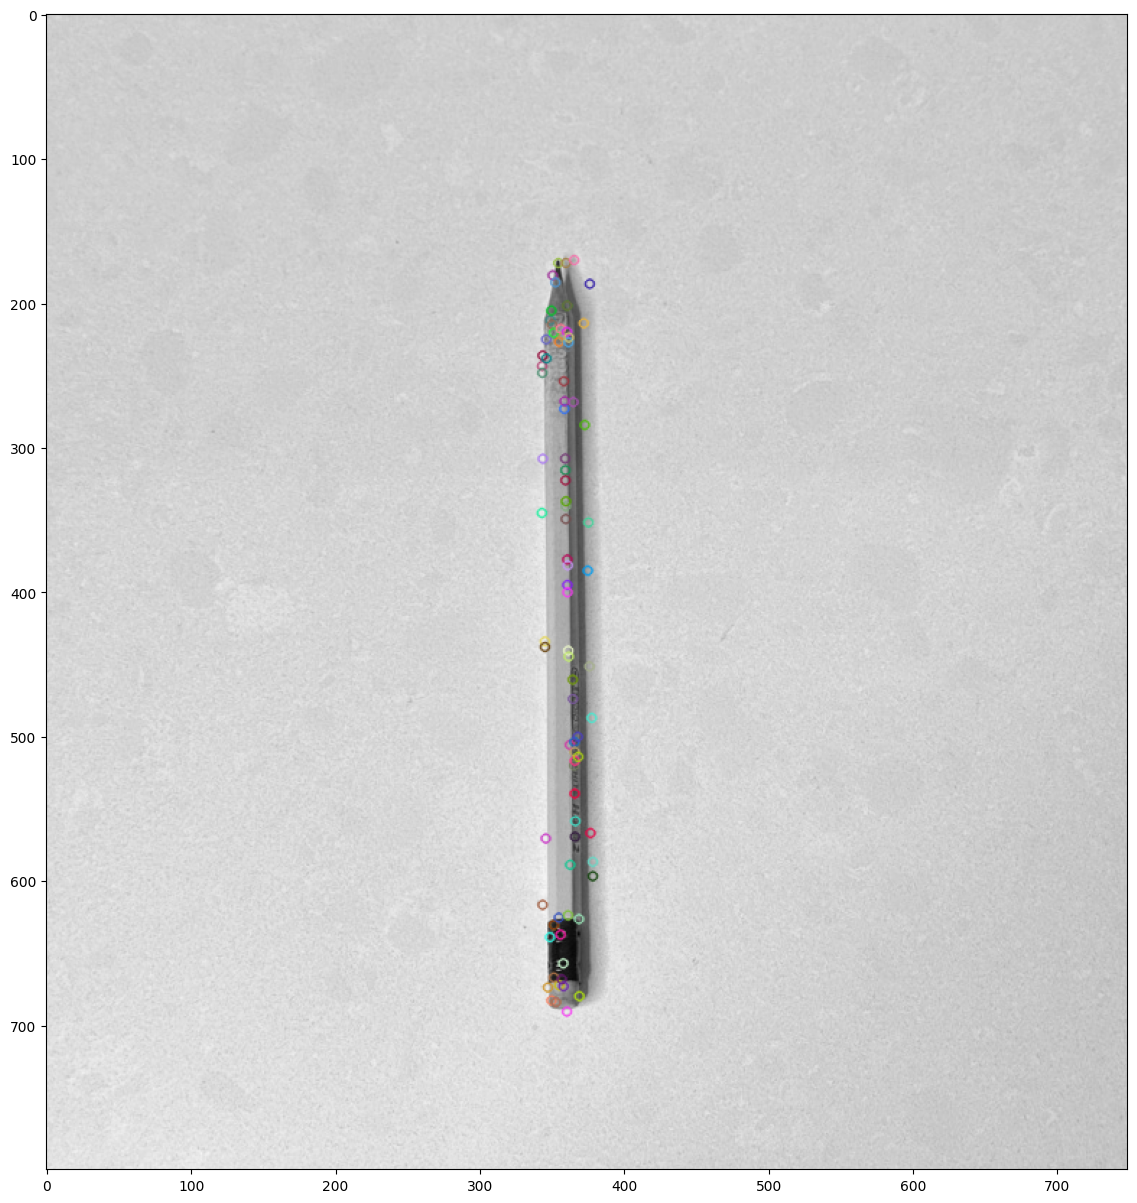

In [34]:
sift = cv2.SIFT_create()  # Lower value for more keypoints         # Higher value to allow more edge-like keypoints
img = cv2.imread(object_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
kp, des = sift.detectAndCompute(img, None)
img_kp = cv2.drawKeypoints(img, kp, img)

plt.figure(figsize=(15, 15))
plt.imshow(img_kp); plt.show()

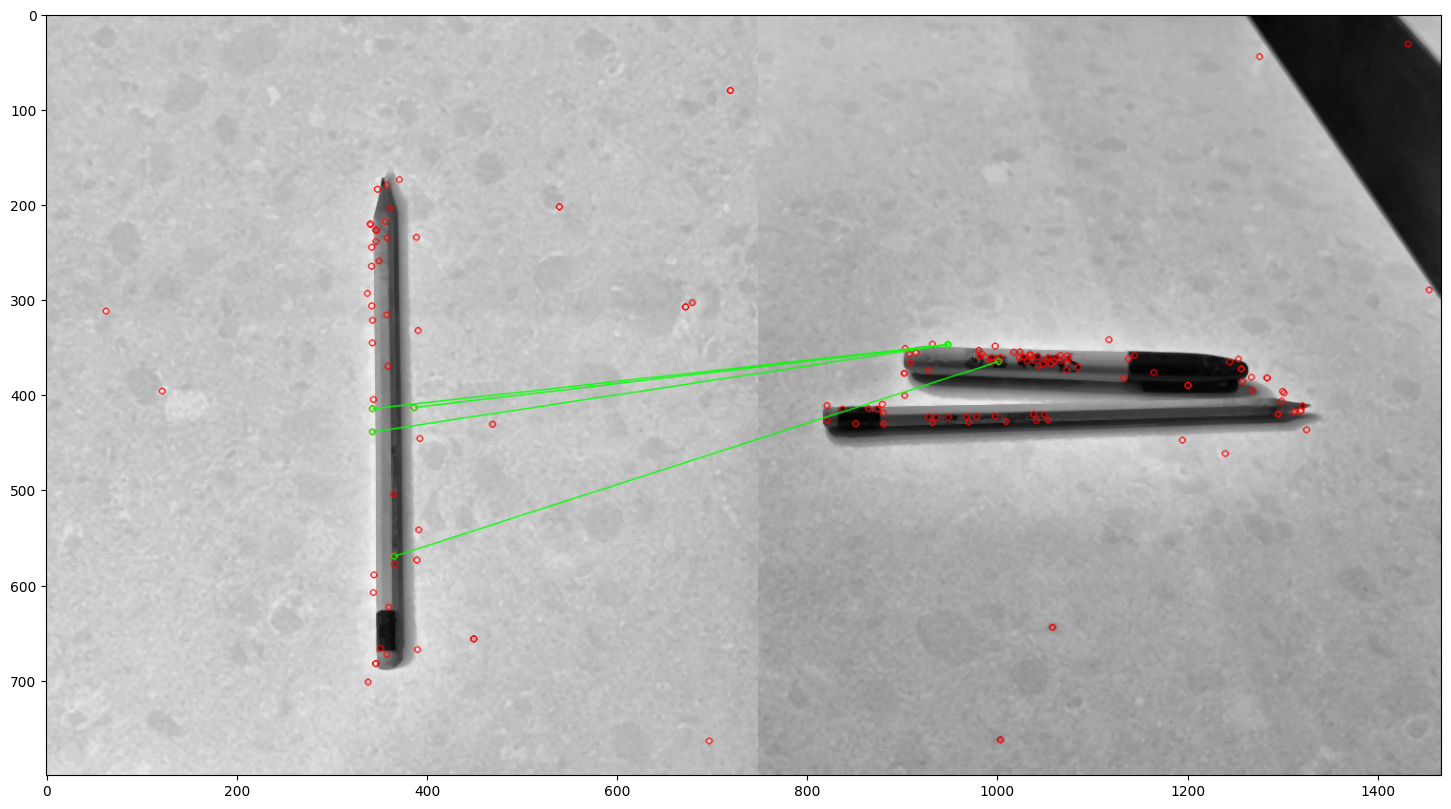

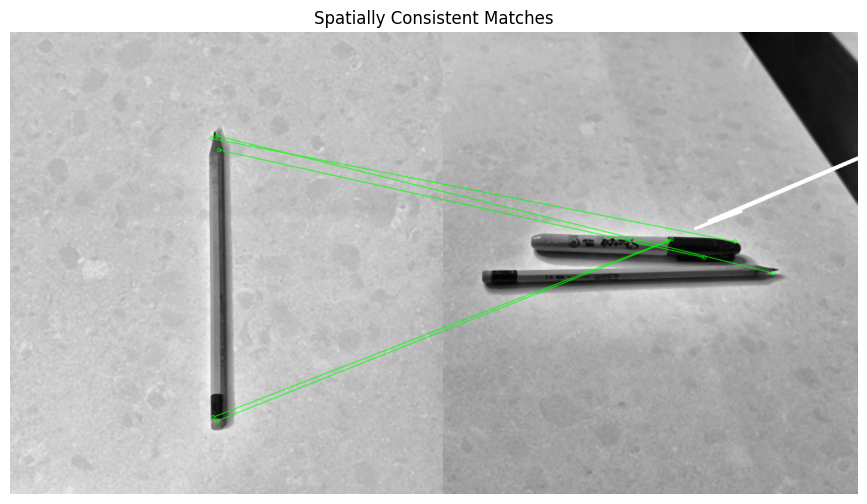

In [35]:
img1, kp1, des1 = image_detect_and_compute(sift, object_image_path, apply_clahe=True, apply_blur=True, blur_type="median", kernel_size=5)
img2, kp2, des2 = image_detect_and_compute(sift, scene_image_path, apply_clahe=True, apply_blur=True, blur_type="median", kernel_size=5)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1, des2, k=2)

matchesMask = [[0, 0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < 0.6*n.distance:
        matchesMask[i] = [1, 0]

draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask,
                   flags=0)

img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)
plt.figure(figsize=(18, 18))
plt.imshow(img3); plt.show()


H, matches_mask = match_and_verify(sift, object_image_path, scene_image_path)